## Tensor contractions

The following code performs the contraction:

$$
M_{pqrs} = \sum_{ABCD} S_{pA}T_{qB} U_{rC} V_{sD} I_{ABCD}
$$

In [ ]:
import numpy as np


def contract_to_M(I: np.ndarray, S: np.ndarray, T: np.ndarray, U: np.ndarray, V:np.ndarray) -> np.ndarray:
    M = np.zeros((S.shape[0], T.shape[0], U.shape[0], V.shape[0]))

    for p in range(M.shape[0]):
        for q in range(M.shape[1]):
            for r in range(M.shape[2]):
                for s in range(M.shape[3]):
                    for A in range(I.shape[0]):
                        for B in range(I.shape[1]):
                            for C in range(I.shape[2]):
                                for D in range(I.shape[3]):
                                    M[p, q, r, s] += S[p, A] * T[q, B] * U[r, C] * V[s, D] * I[A, B, C, D]

    return M

1. What are the _Big-O_ estimates for the number of FLOPS and the amount of memory required?
2. How would you check that your estimates are in the right ballpark?
3. Rearrange the function such that the _Big-O_ estimate for the number of FLOPS is minimized. How are the _Big-O_ estimates for the memory affected?
4. Write tests to make sure the behaviour is consistent between the original and the rearranged versions of the code.

## <span style='color:blue'> Answer </span>

Well let's have a look on this problem using **quimb**. Suppose we have random tensors that one of them **I** has common index with others **S, T, U, and V**.

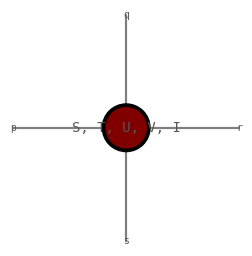

In [ ]:
import quimb as qu
import quimb.tensor as qtn 

I = qtn.rand_tensor(shape = [4,4,4,4], inds = ['A', 'B', 'C', 'D'], tags='I')
S = qtn.rand_tensor(shape = [3,4], inds = ['p','A'], tags='S')
T = qtn.rand_tensor(shape = [3,4], inds = ['q','B'], tags='T')
U = qtn.rand_tensor(shape = [3,4], inds = ['r','C'], tags='U')
V = qtn.rand_tensor(shape = [3,4], inds = ['s','D'], tags='V')

res = S@T@U@V@I
res.draw(node_color='maroon',
         node_outline_darkness=.1,
         figsize=(10,3),
         edge_color='black')

**1. What are the _Big-O_ estimates for the number of FLOPS and the amount of memory required?**

Well, to answer to this question, I would say we have some indexes that will contract with each others and we can call them as an inner indexes (A, B, C, D) and some outer indexes (p, q, r, s) that doesn't have any contractions. 

In the code that is provided by the host we can see $8$ nested loops which increase the computational cost by $O(N^8)$ where $N$ represents the dimensions of the each matrices.

For the memory requirement, I would say that RAM is the place to store inputs and outputs. Then we should calculate how much storage we need for input matrix and how much for the output. Here the point is about largest term among input matrixes that always dominant and take the major part of the memory and no need to consider low dimension tensors in the presence of large tensors. Consider this explanation the largest tensor among input tensors is $I_{ABCD}$ which its respective dimension is  $O(N^4)$ and the output matrix is $M_{pqrs}$ with respective dimension $O(M^4)$. This tells us that the memory usage is $I+M$

**2. How would you check that your estimates are in the right ballpark?**

Well mainly the structure of the code tells us how much it is efficient but for check the code we have some tools like *time* library for evaluation the runtime. 

Also for evaluating the memory usage we can use libraries like *tracemalloc* which is effectively monitor the memory usage. 

Moreover for the CPU usage in some cases we should use *psutil* library


**3. Rearrange the function such that the _Big-O_ estimate for the number of FLOPS is minimized. How are the _Big-O_ estimates for the memory affected?**

For this part I will rearrange the code in two ways. one of them using *np.tensordot* and another one using *np.einsum*. First lets make a class the funstions.

In [ ]:
import numpy as np

class tensor_contract():
    def __init__(self, I, S, T, U, V):
        self.I = I
        self.S = S
        self.T = T
        self.U = U
        self.V = V

    def contract_to_M(self):
        M = np.zeros((self.S.shape[0], self.T.shape[0], self.U.shape[0], self.V.shape[0]))

        for p in range(M.shape[0]):
            for q in range(M.shape[1]):
                for r in range(M.shape[2]):
                    for s in range(M.shape[3]):
                        for A in range(self.I.shape[0]):
                            for B in range(self.I.shape[1]):
                                for C in range(self.I.shape[2]):
                                    for D in range(self.I.shape[3]):
                                        M[p, q, r, s] += self.S[p, A] * self.T[q, B] * self.U[r, C] * self.V[s, D] * self.I[A, B, C, D]

        return M

    def contract_to_M_tensordot(self):
        M = np.tensordot(self.I, self.V, axes=(3, 1)) 
        M = np.tensordot(M, self.U, axes=(2, 1)) 
        M = np.tensordot(M, self.T, axes=(1, 1)) 
        M = np.tensordot(M, self.S, axes=(0, 1))  
        return M

    def contract_to_M_einsum(self):
        M = np.einsum('ABCD, pA, qB, rC, sD->pqrs', self.I, self.S, self.T, self.U, self.V)
        return M

Now we can have a look on the time evaluation for these three methods

In [ ]:
I = np.random.rand(4, 4, 4, 4)
S = np.random.rand(3, 4)
T = np.random.rand(3, 4)
U = np.random.rand(3, 4)
V = np.random.rand(3, 4)

contractor = tensor_contract(I, S, T, U, V)

In [ ]:
import time

start_h = time.time()
host = contractor.contract_to_M()
end_h = time.time()
print("host_code_runtime:", end_h - start_h)
start_d = time.time()
M_tdot = contractor.contract_to_M_tensordot()
end_d = time.time()
print("tensordot_runtime:", end_d - start_d)
start_e = time.time()
M_einsum = contractor.contract_to_M_einsum()
end_e = time.time()
print("einsum_runtime:", end_e - start_e)

host_code_runtime: 0.09019947052001953
tensordot_runtime: 0.0009753704071044922
einsum_runtime: 0.0006814002990722656


In [ ]:
import tracemalloc

tracemalloc.start()
result = contractor.contract_to_M()
_, h_peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop() 
print("host_peak_memory_usage:", h_peak_memory)

tracemalloc.start()
result = contractor.contract_to_M_tensordot()
_, d_peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop() 
print("tensordot_peak_memory_usage:", d_peak_memory)

tracemalloc.start()
result = contractor.contract_to_M_einsum()
_, e_peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop() 
print("einsum_peak_memory_usage:", e_peak_memory)

host_peak_memory_usage: 21460
tensordot_peak_memory_usage: 19920
einsum_peak_memory_usage: 398160


**4. Write tests to make sure the behaviour is consistent between the original and the rearranged versions of the code.**

To become ensure about the original and rearranged version I would say that we can use *np.allclose* in a function that return us the boolean.

In [ ]:
def test_contract(func_1, func_2):
    if np.allclose(func_1, func_2) == True:
        return 'successful'
    else:
        return 'unsuccessful'

I am considering the host approach as a true answer and I will compare the other codes with that

In [ ]:
host = contractor.contract_to_M()
M_tdot = contractor.contract_to_M_tensordot()
M_einsum = contractor.contract_to_M_einsum()

print('the test result for the tensordot approach is', test_contract(host, M_tdot))
print('the test result for the einsum approach is', test_contract(host, M_einsum))


the test result for the tensordot approach is unsuccessful
the test result for the einsum approach is successful
